## Goal of this notebook

Explain what NLPers and data scientists mean with they talk about topics,
and what the related analyses can do for you.





## Topics in text - a somewhat vague question

There isn't really a singular thing called 'topic analysis' or some such term - yet there are a number of specific methods that come to mind. 


This does make the goal a little inclear, though. 
You can ask

- Are you searching known documents? Are you organizing unseen documents? 

- Do you want it to guess without intervention, or do you want to guide it precisely?

- Do we want it to estimate the closest fitting labels from a large _but_ controlled set, 
  or do we want it to estimate from just the document set you give it?

- Is it identifying topics in one document at a time (e.g. to describe the common ones), 
  or is it looking for topics that segmenting a specific set of documents?

- Do we do so _by_ identifying subject matter,
  or does subject matter merely emerge out of grouping similar words, and then only sometimes?

The thing is that each of these is valuable, in different circumstances.
<!--
Even just the question whether you want 
- are willing to build hardcoded rules into what almost amounts to a classical expert system.
- want to give it a lot of examples of text and according classes (supervised learning)
- control of the labels but little lese
- a fully automatic thing with no parameters at all, we'll see what it spits out (unsupervised learning)
-->


**Topic classification** might refer to _any_ type of text classification 
''where the classes happen to be descriptive of the subject matter''.

It is generally understood to be a more supervised technique, but not a specific one. 
Each method you might ue might have its own ideas and idiosyncracies.

<!--
(And while we're being fuzzy about it, isn't we we now call
**sentiment analysis** just a classification task with two classes?)
-->

### Topic modeling

From the context of the above, **topic modelling** is a little more specific, 
and a term that recently gained some interest.

It is a statistical/machine learning, and unsupervised (a.k.a. "I don't have to annotate a lot of examples first".

It draws on the <a href="https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_hypothesis">distributional hypothesis</a> (which implies that words occuring in similar contexts probably convey similar meanings - "a word is characterized by the company it keeps"), 
but (unlike LSA/LSI) goes on to makes one further assumption, 
namely that documents are each about a fairly singular subject matter.

<!-- -->
This that lets us expect that particular words to appear in each document more or less frequently.

Under that assumption we can make some stronger assumptions about how much a word appears in each,
and how comparable that is to others. 

It tends to find words co-occuring words for the subject matter.

And we choose to call such detected sets of words 'topics' (which is why the wording above was avoiding that term),
and a number of them will indeed be coherent enough in their subject matter 
that we might look at it and intuit a label we can put to it.

Even if these topic-groups are fuzzier and we can intuit no clear label for it, 
they will will have _some_ amount of distinguishing power,
and might still be good for some tasks.



The thing is that, like many unsupervised techniques, 
you have little contol over whether your data meets its requirements,
so if that affects the results to be better or worse, that's just how it is.

**If** you have unusually clean output, you can start dreaming of it being useful to:
- give a bird's eye view of the themes common in your document set,
- suggest related words,
- group documents,
- describe main topics in documents
- classify text
- index text


However, that "documents should be uniformly about one topic" is easily also a weakness,
in that it does not necessarily work on large varied documents, or on sort fragments from them.

tl;dr:
So topic modelling is interesting as an **explorative technique** to get some insight
into documents when they are ,
and easy to do because it **does _not_ require up-front work**,
**but its output is not always equally useful**.

It relies on a number of conditions and assumptions (the largest probably being your documents having singular topics),
but when they are met it works better than you might expect from something requiring zero training
and perhaps only thousands of documents.


Also, **There is no canonical method**, so the quality of the output varies between 
methods and implementatins, even some coarse tuning can have considerable effect,
and features that some implementatins add to the basics aren't uniquitous.

### Let's see some of those claims be supported by examples

In [1]:
import os
import re
import random
import pprint
import collections
import gensim.utils

import wetsuite.datasets
import wetsuite.helpers.etree
from wetsuite.helpers.notebook import ProgressBar
import wetsuite.helpers.koop_parse
import wetsuite.helpers.spacy
import wetsuite.extras.word_cloud

The "20 newsgroups" dataset is a sampling of [usenet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) (forum-like things) from a while ago.

We happen to know these are small messages that have fairly distinct topics of discussion.

We also know where they belong from their group name (things like 'alt.atheism', 'talk.religion.misc', 
'sci.space','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'rec.sport.hockey')
but we throw away that knowledge, and see if we would discover those patterns.

In [24]:
from sklearn.datasets import fetch_20newsgroups  


justdocs = []
for doc in fetch_20newsgroups(
        subset='all',     # merge what it considers training and test data
        categories=None,  # You would notmally also fetch the set each message is in, but we purposefully forget that
        remove=('headers',)
    ).data: # the message have metadata relating to how things were sent, strip that

    # the first lines of the message is often a reference to who wrote it, using a messy address, that we can lose
    lines = doc.splitlines()
    #print(repr(lines[0]))
    while len(lines)>0 and lines[0].endswith(' writes:'):
        lines.pop(0)
        #print( 'removed %r'%lines.pop(0) )
    if len(lines)>0:
        doc = '\n'.join(lines)
        justdocs.append( doc )

len(justdocs)

18840

In [25]:

# There is an argument that, if you use LDA correctly, stopwords do not reduce the effectiveness much.
# Yet the presentation below will look cleaner if we do, 
# so for this example we even remove somewhat aggressively, hoping for more noun-looking results.
stop_en = '''the to and that it you for not be on this have are as was with he if but or can they at 
             what of in is from has his all an by from there do me we my when so him up no about
             than were out will your would just get who their which its been them more
             some any then our those only many much
             one other had these like said did into also
             com edu article writes'''.split()

def split_paragraphs(text):
    ' Taken a string, returns a list of string, that input split by two or more successive newlines. '
    return re.split(r'\n{2,}',text) # TODO: deal with just-space lines. Code for that exists somewhere.
 
def text2tokens(text, stop):
    ' tokenize, lowercase, remove accents, removes stopwords '
    ret = []
    for phrase in gensim.utils.simple_preprocess(text, deacc=False, min_len=2, max_len=20):
        if phrase.lower() not in stop:
            ret.append( phrase )
    return ret


class ShowTopTerms:
    '  '
    def __init__(self, topic_model, thresh=0.1, num_topics=50, num_words=30, filter_topics=None):
        self.topic_model   = topic_model
        self.num_topics    = num_topics
        self.num_words     = num_words
        self.thresh        = thresh
        self.filter_topics = filter_topics
    def _repr_html_(self):
        ret = []
        ret.append('<div>')
        for topic_num, ll in self.topic_model.show_topics(num_topics=self.num_topics, num_words=self.num_words, formatted = False):
            if self.filter_topics is not None  and  topic_num not in self.filter_topics:
                continue
            maxrel = ll[0][1]
            ret.append('<div><b>TOPIC %d</b>: '%topic_num)
            for phrase, rel in ll:
                ret.append('&nbsp; <span style="opacity:%.1f">%s</span>'%( rel/maxrel, phrase))
                if rel < self.thresh * maxrel:
                    break
            ret.append('</div>')
        ret.append('</div>')
        return ''.join(ret)

In [ ]:
choice = random.choice(justdocs)        
print( text2tokens(choice, stop_en) ) # as a check that text2tokens works
print( choice )                               


In [26]:
# If you care about why gensim wants you to make a dictionary, and a corpus referring into it
# - a dictionary here means "we are a computer so work on numbers; this is the thing that remembers each number indicates a word"
# - a corpus of documents. It amounts to per-documents counts 
#   (which, due to the dictionary, can be (phraseid,count) rather than (text,count))
dic = gensim.corpora.Dictionary()
corpus_gensim = []                # list of documents,  each is a list of (phraseid, frequency)

for doc_text in ProgressBar( justdocs ):
    # take text as a whole, and reduce to a list of phrases 
    # (in this example single words, but we're keeping our options over)
    doc_tokens = text2tokens(doc_text, stop=stop_en)

    # takes a document in list-of-string form, and returns (termid,count) for each based on the dictionary
    #  asking gensim to create entries in that dictionary it as necessary
    doc_id_counts = dic.doc2bow(doc_tokens, allow_update=True) 
    corpus_gensim.append( doc_id_counts )

  0%|          | 0/18840 [00:00<?, ?it/s]

In [27]:
# The above mostly just said 
#  'these are the words/terms we use, and the counts in each document',
#  and we have not done any analysis yet.

# This ask for the actual topic model calculation (using the LDA method). 
#  The target amount of topics is an estimation,
#    and a bit of a choice of how general/specific we try to be.
#  This is one of a few parameters you may want to play with.
topic25  = gensim.models.LdaModel(corpus=corpus_gensim, id2word=dic, num_topics=25)
topic50  = gensim.models.LdaModel(corpus=corpus_gensim, id2word=dic, num_topics=50)
topic100 = gensim.models.LdaModel(corpus=corpus_gensim, id2word=dic, num_topics=100)
# Given the modest size of 20newsgroups, those may take a minute each

In [28]:
# What did we achieve?  What do we have?
#  Well, let's get it to show us topics (which are not labeled, just numbered),
#  and for each topic their top terms, and their contribution
topic25.show_topics(num_topics=10, num_words=10, formatted=True) # default is formatted=True;  False gives it as data

[(20,
  '0.011*"kinsey" + 0.007*"henry" + 0.004*"motto" + 0.004*"toronto" + 0.004*"runs" + 0.004*"time" + 0.004*"good" + 0.004*"average" + 0.004*"don" + 0.003*"hit"'),
 (0,
  '0.005*"mm" + 0.005*"ma" + 0.005*"mv" + 0.004*"mp" + 0.004*"mr" + 0.004*"md" + 0.004*"mo" + 0.004*"mk" + 0.004*"bh" + 0.004*"el"'),
 (2,
  '0.007*"game" + 0.006*"israel" + 0.004*"israeli" + 0.004*"time" + 0.004*"know" + 0.004*"go" + 0.004*"don" + 0.003*"off" + 0.003*"first" + 0.003*"apr"'),
 (3,
  '0.027*"bike" + 0.021*"dod" + 0.014*"db" + 0.012*"ca" + 0.009*"bmw" + 0.009*"ride" + 0.006*"bikes" + 0.006*"org" + 0.006*"motorcycle" + 0.006*"bnr"'),
 (6,
  '0.006*"key" + 0.006*"people" + 0.006*"government" + 0.005*"use" + 0.004*"gun" + 0.004*"public" + 0.004*"don" + 0.004*"how" + 0.004*"law" + 0.003*"could"'),
 (15,
  '0.010*"people" + 0.007*"think" + 0.007*"don" + 0.005*"know" + 0.005*"how" + 0.005*"say" + 0.005*"god" + 0.005*"because" + 0.004*"us" + 0.004*"does"'),
 (22,
  '0.013*"card" + 0.009*"windows" + 0.008*"an

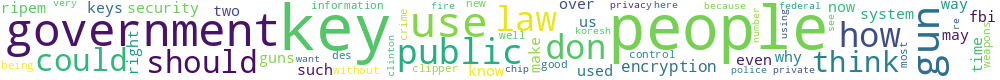

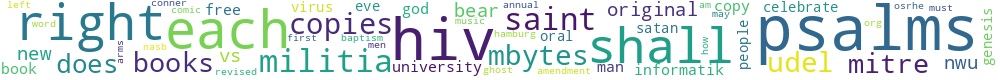

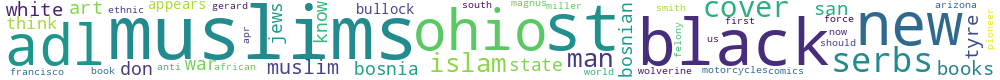

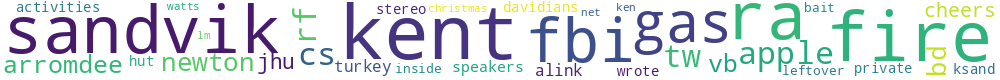

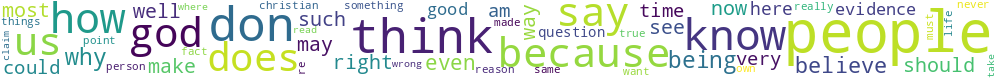

In [29]:
# That's hard to read.  How about something more visual, like word clouds?
for _, wl in topic25.show_topics(num_topics=5, num_words=100, formatted=False): # just a few
    freqs = {} # get that back into a dict (there may well be a shorter way)
    for word, rel in wl:
        freqs[word] = rel
    display( wetsuite.extras.word_cloud.wordcloud_from_freqs( freqs, width=1000, height=80 ) )

In [30]:
# okay, fancy, but how about something a little more compact and skimmable?   We defined a class earlier that lets us do:
ShowTopTerms( topic25, thresh=0.3, num_words=100 ) # cleaner output by not showing words that contributed < 0.2 * the maximum one within the topic

# we can imagine that too few topics means unnatural merging, too many is awfully specific, and that there is a middle way.   
# You could stare and compare to figure out how different they are. 

In [32]:
ShowTopTerms( topic100, thresh=0.2, num_topics=50, num_words=25 )

In [33]:
# we can also e.g. match text to these
for unseen_text in (
    "I like macintosh computers and do not do backups onto floppy drives",
    "I believe god likes an atheist, gives them something to aim at",
    "A new car is a joy to drive and stick shift is hard",
):
    toks = text2tokens(unseen_text, stop=stop_en)
    print( '---- %s ----'%toks )
    unseen_doc      = topic100.id2word.doc2bow( toks )
    matching_topics = topic100.get_document_topics( unseen_doc )  # note: get_document_topics() is also what happens if you do t80[unseen_doc]
    
    # as a reminder of what it's matching
    for topic_num, score in sorted( matching_topics, key=lambda x:x[1], reverse=True )[:2]:
        #print ('score=%.3f for: '%(score))
        display( ShowTopTerms( topic100, filter_topics=[topic_num], num_topics=1000 ) )

---- ['macintosh', 'computers', 'backups', 'onto', 'floppy', 'drives'] ----


---- ['believe', 'god', 'likes', 'atheist', 'gives', 'something', 'aim'] ----


---- ['new', 'car', 'joy', 'drive', 'stick', 'shift', 'hard'] ----



All in all, not bad for something that _even knows what words are_ 
and just considers them certain _things_ that appear together.

Some of those topics even look useful, coherent enough that you might give them your own labels,
and use them as basis for a classifier or such, suggest related terms, or whatnot.

Other parts look quite messy. Also, the above has plenty of cherry picking, massaging, and training choices, and informed visualisation thresholds.
(And this is before we get into tweaking parameters like `alpha` and `eta`, which both amount to smoothing - 
[e.g. this tutorial goes into that somewhat](http://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html#Understanding-the-role-of-LDA-model-hyperparameters)).



In [145]:
#If we were to use this more blindly, things would look more like the following, 
#which sometimes pops up similar coherence, but is certainly messier:

# this is from a past run with stopwords disabled
ShowTopTerms( topic100, 0.001, num_words=100 )

Back to the cleaner version. 

People have made visualizations of the results, which may also do some further analysis.

Consider the following: 

In [34]:
import pyLDAvis, pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic100, corpus_gensim, dic)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27    -0.190110 -0.106093       1        1  6.402116
4     -0.201366 -0.070654       2        1  6.386289
67    -0.194264 -0.085233       3        1  4.514064
55    -0.171780 -0.033540       4        1  3.885222
18    -0.174875 -0.094292       5        1  3.392619
...         ...       ...     ...      ...       ...
12     0.139350 -0.105676      96        1  0.213412
51     0.105567 -0.041523      97        1  0.212674
62     0.076887 -0.048799      98        1  0.200870
58     0.143706  0.036615      99        1  0.200547
59     0.162115  0.016724     100        1  0.149312

[100 rows x 5 columns], topic_info=           Term          Freq         Total  Category  logprob  loglift
28730        ax  68613.000000  68613.000000   Default  30.0000  30.0000
3372        god   6198.000000   6198.000000   Default  29.0000  29.0000
611         max   4254.000000   4254.000000   Default  28.0000  28.0000
696         she   2550.000000   2550.000000   Default  27.0000  27.0000
2498        key   2320.000000   2320.000000   Default  26.0000  26.0000
...         ...           ...           ...       ...      ...      ...
14500      suit     30.125495    116.026649  Topic100  -4.9292   5.1584
6           bit     42.741109   2694.924037  Topic100  -4.5794   2.3629
61       anyone     35.297673   4608.228452  Topic100  -4.7708   1.6351
739     species     24.393050    145.350092  Topic100  -5.1403   4.7220
389    possible     25.154638   2049.105095  Topic100  -5.1095   2.1068

[6698 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
13407     78  0.934653  a_rubin
5126      54  0.983593      aap
19390     72  0.894353      aau
571        9  0.013301      abc
571       16  0.119708      abc
...      ...       ...      ...
17151     81  0.538919     zoom
12908      6  0.595449       zx
12908     33  0.016540       zx
12908     46  0.374912       zx
12908     62  0.005513       zx

[53715 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 5, 68, 56, 19, 76, 58, 89, 50, 9, 62, 36, 72, 12, 86, 27, 39, 38, 48, 7, 10, 26, 91, 98, 78, 95, 73, 46, 18, 44, 49, 30, 80, 54, 14, 70, 34, 41, 66, 6, 22, 100, 21, 61, 4, 83, 40, 53, 64, 23, 69, 88, 3, 25, 37, 51, 45, 99, 11, 57, 55, 92, 74, 17, 75, 96, 90, 33, 87, 29, 20, 47, 32, 65, 81, 71, 15, 1, 67, 93, 24, 31, 8, 85, 84, 43, 35, 42, 77, 94, 97, 82, 79, 2, 16, 13, 52, 63, 59, 60])

The circles on the left each represent a topic.
- circle size is how well represented this topic is                          - often meaning that more of its words are common?
- circle position is based on how dissimilar we think different topics are   - based on additional analysis this visualization adds, and was not part of the topic model

The bars also have more going on than in the model.
- blue bars show how common the term is in general,   (...showing the subset of term in the topic we are currently looking at)
- the red bars within a blue bar _estimate_ how important this term is within the current topic (keep in mind each term is a member of _multiple_ topics)
- the 'relevance metric' slider controls how terms are sorted (and how the red is) 
  - To the right sorts by frequency within the model
  - To the left sorts by how much a term stands out between topics
  - inbetween blends those two, which seems most useful to interpret the topic
  - the most common terms stay on top, but playing with that slider helps discover what the topic is about

## Topic modeling on some legal text

The 20newsgroups set is a relatively clean example,
in that we know each document stays _broadly_ within a single subject,
and is short so doesn't _mix_ topics much either.

That descrition does not match most _any_ longer text,
and presumably most legal text is neither short or about just a single thing.

Let's feed it some, and see what happens. Let's 
- look at some different kinds of text
- feed shorter fragments in at a time (currently tries for paragraphs and this may be overly short - we might increase that to longer sections where we can)

Note that a full set of any one source will have tens or hundreds of thousands of documents,
Just tokenizing those will take only a few minutes. 

Most of the implied time is actually in the analysis step because techniques like LDA 
high time complexity - runtime rises somewhat unreasonably with ain increased amount of input,
so for quick experments, keep the doc count down to perhaps ~10K documents worth,
so that that analysis takes only a few minutes.

In [46]:
legal_text_docs = []

cvdr_mostrecent_text = wetsuite.datasets.load('cvdr-mostrecent-text')
legal_text_docs.extend( doc                    for _, doc in cvdr_mostrecent_text.data.random_sample(6000) )

bwb_mostrecent_text  = wetsuite.datasets.load('bwb-mostrecent-text')
legal_text_docs.extend( doc                    for _, doc in bwb_mostrecent_text.data.random_sample(6000) )

rechtspraak_struc    = wetsuite.datasets.load('rechtspraaknl-struc')
for _, meta in rechtspraak_struc.data.random_sample(6000):
    txt = meta.get('conclusie')
    if txt is None:
        txt = meta.get('uitspraak')
    if txt is None:
        raise ValueError(meta)
    legal_text_docs.append( txt )
    
# there was a bug in older version of the rechtspraaknl-struc dataset where the text would be a list instead. TODO: remove the need for the follwing code
legal_text_docs = list(  txt_doc  for txt_doc in legal_text_docs  if isinstance(txt_doc, str)  )
len(legal_text_docs)

17941

In [47]:
# note that stoplisting removes a thing from being considered _completely_, and is often best done conservatively. 
#  say, 'om' may be an empty adposition, but if you add it here, be sure you didn't care about abbreviated references to the openbaar ministerie
# So the following is somewhat aggressive stoplisting, a specific experiment to try to focus more on nouns.
stop_nl = '''
de deze van het een en in of is op voor te aan die met niet bij zijn als dat tot door dan uit ook onder
bent ten naar over zal kan er dit kan ter hem hij zij ze der
had ziet laat wat hem moet maar dus zo om binnen na heeft hebben
bedoelde werd wordt worden bedoeld hiervan artikel lid
'''.split()

# for the gensim setup details, see the example above
dic = gensim.corpora.Dictionary() 
corpus_gensim = []                

for txt_doc in ProgressBar( legal_text_docs ):
    try:
        for paragraph_text in split_paragraphs( txt_doc ):
            toks = text2tokens(paragraph_text, stop=stop_nl)
            #nps = wetsuite.helpers.spacy.nl_noun_chunks( paragraph_text )
            #print(nps)
            #toks.extend( nps )
            if len(toks) > 0:
                #print( toks )
                doc_id_counts = dic.doc2bow(toks, allow_update=True)
                corpus_gensim.append( doc_id_counts )
    except Exception as e:
        print('ERROR: %s'%e)
        #raise


  0%|          | 0/17941 [00:00<?, ?it/s]

In [48]:
c100 = gensim.models.LdaModel(corpus=corpus_gensim, id2word=dic, num_topics=150)

In [50]:
ShowTopTerms( c100, thresh=0.3, num_topics=100, num_words=70 )

In [45]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(c100, corpus_gensim, dic)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
82     0.345085  0.043535       1        1  6.477316
41     0.147600  0.142138       2        1  1.804152
127    0.155820  0.187936       3        1  1.339942
71     0.003559 -0.044147       4        1  1.311276
6      0.079781 -0.238326       5        1  1.254885
...         ...       ...     ...      ...       ...
73    -0.080853  0.013151     146        1  0.322378
0     -0.081108  0.040696     147        1  0.321558
56    -0.023384  0.053837     148        1  0.308419
145   -0.091720  0.017371     149        1  0.279545
54    -0.102281  0.004112     150        1  0.276798

[150 rows x 5 columns], topic_info=           Term          Freq         Total  Category  logprob  loglift
4957  verdachte  54850.000000  54850.000000   Default  30.0000  30.0000
5704  rechtbank  53117.000000  53117.000000   Default  29.0000  29.0000
231     besluit  48769.000000  48769.000000   Default  28.0000  28.0000
205      beroep  39749.000000  39749.000000   Default  27.0000  27.0000
17         haar  40919.000000  40919.000000   Default  26.0000  26.0000
...         ...           ...           ...       ...      ...      ...
9533        mwh      0.012529      2.001926  Topic150 -14.6265   0.8158
1279    bepaald     39.142533  10189.195414  Topic150  -6.5796   0.3278
865     daaraan      6.949722   6216.764307  Topic150  -8.3081  -0.9067
509     alsmede      4.957516   6902.141112  Topic150  -8.6459  -1.3490
605     overige      1.548300  16344.066771  Topic150  -9.8096  -3.3748

[5763 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1054    122  0.996407            aa
9216    140  0.996592  aanbesteding
501     118  0.992100     aanbieden
501     147  0.004561     aanbieden
7197     89  0.980285     aanbieder
...     ...       ...           ...
45        1  0.002072           één
45        4  0.070590           één
45        6  0.926953           één
45       70  0.000077           één
45       82  0.000077           één

[10998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[83, 42, 128, 72, 7, 21, 13, 43, 76, 142, 28, 62, 123, 94, 71, 63, 19, 143, 93, 133, 119, 115, 122, 108, 150, 52, 124, 2, 92, 54, 23, 75, 12, 138, 59, 61, 96, 135, 84, 110, 10, 95, 80, 44, 27, 22, 4, 136, 36, 49, 130, 65, 121, 14, 60, 5, 46, 9, 18, 51, 86, 66, 111, 113, 25, 79, 20, 88, 91, 131, 34, 73, 102, 11, 33, 104, 117, 45, 114, 17, 68, 90, 125, 134, 103, 77, 141, 139, 106, 101, 78, 48, 3, 15, 148, 38, 70, 118, 99, 112, 37, 24, 147, 98, 126, 56, 85, 149, 120, 6, 144, 31, 107, 67, 109, 29, 16, 89, 26, 69, 87, 50, 53, 58, 100, 35, 32, 132, 105, 41, 82, 47, 8, 140, 64, 127, 129, 40, 30, 81, 137, 97, 39, 116, 145, 74, 1, 57, 146, 55])

In [50]:
from importlib import reload
reload(wetsuite.datacollect.eurlex)
import wetsuite.datacollect.eurlex

stop_nl = '''
de deze van het een en in of is op voor te aan die met niet bij zijn als dat tot door dan uit ook onder
bent ten naar over zal kan er dit kan ter hem hij zij ze der
had ziet laat wat hem moet maar dus zo om binnen na heeft hebben
bedoelde werd wordt worden bedoeld hiervan artikel lid
'''.split()

# for the gensim setup details, see the example above
dic = gensim.corpora.Dictionary() 
corpus_gensim = []                

dir_docs_nl = wetsuite.helpers.localdata.LocalKV('eurlex_reg_nl.db', key_type=str,value_type=bytes)   # stores url -> html document

for random_url, random_doc in ProgressBar(  dir_docs_nl.items()  ):
    for section_name, section_txt in wetsuite.datacollect.eurlex.extract_html(random_doc)['text']:
        #print(section_name)
        stxt = '\n\n'.join( section_txt)
        #print( stxt )

        try:
            #for ptxt in split_paragraphs( stxt ):
            toks = text2tokens(stxt, stop=stop_nl)
            if len(toks) > 0:
                doc_id_counts = dic.doc2bow(toks, allow_update=True)
                corpus_gensim.append( doc_id_counts )
        except Exception as e:
            print('ERROR: %s'%e)
            raise

  0%|          | 0/130177 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
len( corpus_gensim )

152755

In [ ]:
c100 = gensim.models.LdaModel(corpus=corpus_gensim, id2word=dic, num_topics=25)


In [ ]:
ShowTopTerms( c100, thresh=0.25, num_topics=25, num_words=25 )



### Other methods

The LDA method we are using above is a statistical model that tries to fit co-occurrences. 
It's not aware of words at all - so most of the co-occurrences will be common words, because that's... true.
LDA tutorials often explain that every real stopword on a stopword list avoids messiness later.

This will certainly makes the trained model look cleaner, though there is an argument that [stopword removal barely affects distinguising power](https://www.researchgate.net/publication/318741781_Pulling_Out_the_Stops_Rethinking_Stopword_Removal_for_Topic_Models), so removing them afterwards (if you can) works almost as well, and can be more flexible in that it lets you deal with domain-specific stopwords, and won't overdo it in preprocessing with no measure of the effect of what you removed.



Some other methods used include
- similarly, LSI and LSA can be considered precursors to the LDA approach
- NMF (non-negative matrix factorization), which you can consider a variant of LDA, and there is a soft consensus that LDA tends to be more coherent
- Top2Vec
- BERTopic

Top2Vec and BERTopic focus on word embeddings, and aim to give a blended vector per sentence. 
then use HDBSCAN for clustering


http://www.datascience-in-tourism.com/?p=550

https://maartengr.github.io/BERTopic/index.html


Top2Vec and BERTopic have a lot more moving parts, 
meaning a lot 




That said, since we're already doing NLP things, we could consider using knowledge of the language we are using.

In [3]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(legal_text_docs)


2024-02-13 14:32:35.548134: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 14:32:35.694943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 14:32:39.408146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 14:32:39.411489: I tensorflow/comp

In [4]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0       -1   2960                                  -1_de_van_een_het   
1        0    295                   0_minister_bedoeld_onderwijs_lid   
2        1    274               1_verweerder_eiser_eiseres_rechtbank   
3        2    177                  2_appellant_uwv_appellante_beroep   
4        3    168                  3_college_besluit_uitspraak_heeft   
..     ...    ...                                                ...   
157    156     11  156_verzoeker_tegenverzoek_voorwaardelijk_verw...   
158    157     11         157_inhoudingsplichtige_loon_werknemer_20a   
159    158     11  158_rechterlijk_inburgeringsplichtige_onze_rec...   
160    159     11           159_ruimte_ruimten_waarde_bedrijfsruimte   
161    160     11                160_minderjarige_voornaam_moeder_gi   

                                        Representation  \
0        [de, van, een, het, en, in, voor, is, of, te]   
1    [minister, bedoeld, onderwijs, lid, school, on...   
2    [verweerder, eiser, eiseres, rechtbank, heeft,...   
3    [appellant, uwv, appellante, beroep, uitspraak...   
4    [college, besluit, uitspraak, heeft, dat, afde...   
..                                                 ...   
157  [verzoeker, tegenverzoek, voorwaardelijk, verw...   
158  [inhoudingsplichtige, loon, werknemer, 20a, ve...   
159  [rechterlijk, inburgeringsplichtige, onze, rec...   
160  [ruimte, ruimten, waarde, bedrijfsruimte, bedr...   
161  [minderjarige, voornaam, moeder, gi, kinderrec...   

                                   Representative_Docs  
0    [1.1 Algemene inleiding\n1.2 Definities en beg...  
1    [minister: de minister van Onderwijs, Cultuur ...  
2    [\n\nBij besluit van 28 januari 2022 is aan ei...  
3    [13/2979 WAJONG\n\nDatum uitspraak: 5 oktober ...  
4    [\n201400363/1/A1.\nDatum uitspraak: 14 januar...  
..                                                 ...  
157  [\n\n1\nDe procedure\n\n1.1.\nHet verloop van ...  
158  [Dit besluit is opnieuw uitgebracht voor de to...  
159  [In deze beleidsregel wordt verstaan onder:\na...  
160  [Begripsomschrijvingen \nVoor de toepassing va...  
161  [\nHet procesverloop\nHet procesverloop blijkt...  

[162 rows x 5 columns]

In [22]:
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'   # avoids some specific versioning breakage, though also makes things slower
from top2vec import Top2Vec

2024-02-13 13:24:30.972740: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 13:24:31.133172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# tokenized_docs = []
# for txt_doc in ProgressBar( txt_docs ):
#     try:
#         for paragraph_text in split_paragraphs( txt_doc ):
#             toks = text2tokens(paragraph_text, stop=stop_nl)
#             tokenized_docs.append( toks )
#     except:
#         pass

# #tokenized_docs[:30]

8965

In [ ]:
# quick and dirty
# - "if we've run this before and save that model, load it.  
# -  If not, generate and save it so the next run can just load it"


#test_docs = random.sample( txt_docs, 3000 )

model_filename = "model-doc-%d"%len(justdocs)
if False and os.path.exists( model_filename ):
    print( "Loading %s"%model_filename )
    model = Top2Vec.load( model_filename )
else:
    print( "Generating and saving %s"%model_filename )
    # speed is one of  'fast-learn' (fast bug low quality), 'learn' (balanced), 'deep-learn' (better but slow)
    model = Top2Vec(
        documents=justdocs,
        embedding_model='universal-sentence-encoder',
        speed='learn', workers=3,
        umap_args={'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
        },
        hdbscan_args = {
            'min_cluster_size': 10,
            'min_samples':5,
            'metric': 'euclidean',
            'cluster_selection_method': 'eom'
        }
    )
    model.save( model_filename )

## Okay, what does _that_ model represent?  What's in there?

In [ ]:
help( doc_model )

In [30]:
model.similar_words(['car','drive'], 25)

(array(['driving', 'automobile', 'vehicle', 'driver', 'cars', 'ride',
        'road', 'walk', 'drove', 'drives', 'autos', 'route', 'bus',
        'stick', 'hit', 'driven', 'turning', 'bike', 'taking', 'riding',
        'blow', 'auto', 'blowing', 'walking', 'track'], dtype='<U10'),
 array([0.79580327, 0.70588556, 0.69190533, 0.66537273, 0.65890684,
        0.65846941, 0.64449786, 0.63556451, 0.63122598, 0.61700707,
        0.61460929, 0.61129976, 0.60158843, 0.60082706, 0.59743421,
        0.59437276, 0.59315421, 0.59058435, 0.58919622, 0.58382524,
        0.57772682, 0.57742199, 0.57463895, 0.57213937, 0.57209181]))

In [27]:
topic_words, word_scores, topic_scores, nums = model.search_topics(['car', 'drive'], 3)
topic_words

[array(['um', 'ci', 'oo', 'ye', 'll', 'hmm', 'un', 'uh', 'y_', 'wt', 'on',
        'des', 'way', 'an', 'er', 'eh', 'uu', 'se', 'actually', 'has',
        'huh', 'not', 'of', 'ya', 'it', 'upon', 'in', 'le', 'hm', 'so',
        'one', 'shut', 'umn', 'is', 'out', 'ne', 'got', 'at', 'mm', 'es',
        'tu', 'what', 'au', 'dont', 'bit', 'there', 'the', 'over', 'have',
        'est'], dtype='<U15'),
 array(['chevy', 'honda', 'mazda', 'camaro', 'ford', 'targa', 'bmw',
        'mustang', 'vw', 'toyota', 'nissan', 'convertible', 'car', 'civic',
        'accord', 'automobile', 'cars', 'wagon', 'porsche', 'vehicle',
        'reliability', 'motors', 'motor', 'seagate', 'mileage', 'vehicles',
        'xdm', 'engines', 'stratus', 'engine', 'odometer', 'junk',
        'mechanics', 'xt', 'autos', 'dodge', 'gm', 'lx', 'transmission',
        'proton', 'drive', 'saturn', 'specs', 'continental', 'reliable',
        'lindros', 'accelerator', 'cts', 'viper', 'toshiba'], dtype='<U15'),
 array(['counterstee

In [31]:
topic_words, word_scores, topic_nums = model.get_topics(25)

for topic_num in topic_nums:
    print(  "\ntopic %d"%topic_num  )
    print(  topic_words[topic_num]  )
    print(  'coherence: %.2f' %( sum(word_scores[topic_num][:20])/len(word_scores[topic_num][:20]) )  )

    print( len(model.topic_word_scores[topic_num]) )




topic 0
['article' 'brent' 'edu' 'section' 'eliot' 'clemens' 'agreement' 'hal'
 'writes' 'plaintext' 'nichols' 'gainey' 'signed' 'abstract' 'paragraph'
 'grant' 'sfu' 'recchi' 'phill' 'convention' 'acm' 'derek' 'idiot' 'pat'
 'univ' 'credibility' 'articles' 'campbell' 'upenn' 'probert' 'discussed'
 'hughes' 'allen' 'sincerely' 'bobby' 'among' 'newsletter' 'sic' 'larson'
 'rj' 'neil' 'aclu' 'kratz' 'ucsd' 'gregg' 'phil' 'pens' 'norris'
 'addressed' 'defenseman']
coherence: 0.21
50

topic 1
['waco' 'koresh' 'davidians' 'feds' 'fbi' 'atf' 'fires' 'batf'
 'investigators' 'shelling' 'nist' 'armed' 'executed' 'firing' 'massacres'
 'hostage' 'leland' 'militia' 'ammunition' 'suspect' 'authorities'
 'massacre' 'kratz' 'convinced' 'questioned' 'hasan' 'testimony'
 'cooperation' 'acted' 'firearms' 'explosion' 'execution' 'bullets'
 'investigation' 'guns' 'based' 'terrorism' 'six' 'terrorists' 'grenades'
 'fire' 'firearm' 'homicides' 'wiretaps' 'criminals' 'operation' 'wiretap'
 'citizens' 'terro

In [ ]:
# # TODO: fish the words and weights
# model.get_num_topics()
# topic_words, word_scores, topic_nums = model.get_topics(5)

# for topic in topic_nums:
#     model.generate_topic_wordcloud(topic)

In [34]:
import umap
umap_2dmodel = umap.UMAP().fit_transform(model.document_vectors)

In [45]:
# map original topic ID to a reduced set
#hierarchy = model.hierarchical_topic_reduction(25)
#hierarchy_dict = dict(sum([[(raw_id, i) for raw_id in mapping] for i, mapping in enumerate(hierarchy)], []))

In [36]:
%matplotlib inline 

import matplotlib.pyplot
x, y = umap_2dmodel[:,0], umap_2dmodel[:,1]

fig, ax = matplotlib.pyplot.subplots()
ax.scatter(x,y, color=)
display( fig) 



## Shift to legal data

One thing we were previously sneaking in is embeddings: semantically reasonable coordinates for known words.
The universal-sentence-encoder used above will not not be nearly as useful for dutch, so we have to fall back to simpler things.

In [59]:
# quick and dirty
# - "if we've run this before and save that model, load it.  
# -  If not, generate and save it so the next run can just load it"

test_docs = random.sample( legal_text_docs, 2000 )

model = Top2Vec(
    documents=test_docs,
    speed='fast-learn', 
    workers=6,
    umap_args={'n_neighbors': 10,
            'n_components': 5,
            'metric': 'cosine',
    },
    hdbscan_args = {
        'min_cluster_size': 10,
        'min_samples':5,
        'metric': 'euclidean',
        'cluster_selection_method': 'eom'
    }
)

2024-02-13 14:09:41,383 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-02-13 14:09:47,100 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-02-13 14:12:52,342 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-02-13 14:12:59,403 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-02-13 14:12:59,434 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [61]:
model.get_num_topics()

44

In [69]:
topic_words, word_scores, topic_nums = model.get_topics(35)

for topic_num in topic_nums:
    print(  "topic %2d:  "%topic_num, end='' )
    print(  ', '.join( topic_words[topic_num])  )
    #print(  'coherence: %.2f' %( sum(word_scores[topic_num][:20])/len(word_scores[topic_num][:20]) )  )
#   print( len(model.topic_word_scores[topic_num]) )



topic  0:  terechtzitting, verdachte, vonnis, hof, arrest, tenlastegelegde, slachtoffer, parketnummer, verdediging, gevangenisstraf, kantonrechter, bewezen, raadsvrouw, vordering, bewijsmiddelen, raadsman, strafzaak, rechtbank, voorarrest, advocaat, tenlastelegging, gelegde, vrijgesproken, getuige, ongelijk, benadeelde, man, reconventie, rechter, wrakingskamer, conventie, kennisgenomen, wrakingsverzoek, gerechtshof, verklaarde, verweer, wettig, gezegd, vrouw, dagvaarding, grieven, chevron, cassatieberoep, mrs, geintimeerde, nakosten, veroordeeld, appel, wraking, verschotten
topic  1:  aangevallen, ongegrond, uitspraak, beroep, verweerder, bestreden, bezwaar, appellante, state, appellant, afdeling, awb, hoger, beroepschrift, overwegingen, get, griffierecht, verweerschrift, rechtsgevolgen, belastingkamer, doende, koningin, proceskosten, enkelvoudige, tussenuitspraak, gegrond, uwv, zitting, besluit, rechtbank, abw, vernietigde, rechtsmiddel, rvs, mr, vw, ingestelde, aanleiding, indiener, 

In [56]:
model.similar_words(['constitutie'], 25)

ValueError: 'constitutie' has not been learned by the model so it cannot be searched.

In [16]:
topic_words, word_scores, topic_scores, topic_nums = doc_model.search_topics(keywords=["educatie"], num_topics=10)

topic_words
#for topic in topic_nums:
#    artikel_model.generate_topic_wordcloud( topic, )

ValueError: num_topics cannot exceed the number of topics: 2.

In [23]:
topic_words, word_scores, topic_scores, topic_nums = doc_model.search_topics(keywords=["educatie"], num_topics=2)

topic_words
#for topic in topic_nums:
#    artikel_model.generate_topic_wordcloud( topic, )

[array(['on', 'an', 'aansprakelijk', 'er', 'discussie', 'overheidsdienst',
        'bedrijfsafval', 'not', 'has', 'wao', 'of', 'wedstrijd', 'persoon',
        'in', 'grootte', 'verschil', 'je', 'toekennen', 'is', 'pas',
        'vaker', 'betrekt', 'integraal', 'ne', 'zitgelegenheid', 'no',
        'leefbaarheid', 'alsof', 'stap', 'wbb', 'naleven', 'en',
        'veroorzaken', 'dienst', 'the', 'kampeermiddelen', 'na', 'bewonen',
        'aanverwante', 'voordat', 'uitgangspunt', 'asv', 'aspecten', 'by',
        'relatief', 'automatisch', 'eijsden', 'dit', 'oisterwijk',
        'lossen'], dtype='<U15'),
 array(['geen', 'voor', 'heeft', 'eens', 'nederlandse', 'naar',
        'nederland', 'gewoon', 'zijn', 'welke', 'een', 'waar', 'waarom',
        'bij', 'gaat', 'natuurlijk', 'niet', 'hij', 'nieuwe', 'komt',
        'tegen', 'maar', 'het', 'deze', 'groningen', 'zoals', 'nooit',
        'worden', 'wordt', 'daar', 'veel', 'iemand', 'goed', 'zeker',
        'nijmegen', 'toch', 'mensen', 'doet'


The size of the context relates to how wide you cast the net for related words. 

For example, if you train on a few paragraphs at a time, when you might get things often mentioned in the same list, e.g. looking for 'educatie' might get you 'cultuur, kunst, initiatieven, stimulatie, subsidue' and perhaps some local assocations and perhaps some specific pronouns from typical wording

Whereas when you train on documents, you might get, well, a similar idea - some local associations, but less typical wording, and each topic looks more complete (peuters, pedagogisch, voorschoolse, vroegschoolse, ourderbijdrage)
 




In [ ]:
#model = Top2Vec.load("model-1000")

In [ ]:
dir_docs_nl = wetsuite.helpers.localdata.LocalKV('eurlex_dir_nl.db', key_type=str,value_type=bytes)   # stores url -> html document

for random_url, random_doc in dir_docs_nl.random_sample( 100 ):
    try:
        print(random_url)
        parsed = wetsuite.datacollect.eurlex.extract_html(random_doc)   # that function is where most of the scraping code sits
    

## Topic classification

If you were to 

One is to train a lot of classifiers. 
Say, have one respond selectively to educational topics, one just to economy, one just to permits, and so on.

It is hard to cover all topics, but you can always add more.

It can be hard to decide one overall topic, and it can be hard to get away from that long texts tick more boxes, 
but maybe trying to notice all the things it passes by is useful to you.

It ''can'' be hard to run this efficiently, particularly if you end up creating this as many distinct classifiers.


A classical approach is to not even use machine learning, but to encode expert knowledge into 
a rule-based system. Does it mention most of these words? Then it's about educato